# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
%pip install tensorflow
import tensorflow as tf



Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [3]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Step 1: Initialize tokenizer and fit on the corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1
print("Total unique words:", total_words)


Total unique words: 3375


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [6]:
total_words = len(tokenizer.word_index) + 1
print("Total unique words (vocabulary size):", total_words)


Total unique words (vocabulary size): 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [7]:
# Your code here : Building the n-gram sequences
input_sequences = []

for line in corpus:
    # convert text line to a sequence of integers
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # generate n-gram sequences
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Number of input sequences:", len(input_sequences))


Number of input sequences: 15484


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Find the length of the longest sequence
max_sequence_len = max(len(seq) for seq in input_sequences)
print("Max sequence length:", max_sequence_len)

# Pad all sequences to the same length and convert to numpy array
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
input_sequences = np.array(input_sequences)


Max sequence length: 11


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [9]:
# Your code here :
# Predictors: all tokens except the last one
X = input_sequences[:, :-1]

# Labels: the last token in each sequence
y = input_sequences[:, -1]

print("Predictors shape:", X.shape)
print("Labels shape:", y.shape)


Predictors shape: (15484, 10)
Labels shape: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [ ]:
# Your code here :
from tensorflow.keras.utils import to_categorical  # only if not imported yet
# or: import tensorflow.keras.utils as ku
# now y is a single integer per sample, we need to one-hot encode it
# NN with categorical_crossentropy expect labels in the form of one-hot vectors
# if total_words=1000, then label is a vector of lenth 1000 with one element set to 1, rest 0
# suppose total_words = 5 and label is 2 - one-hot vector is [0,0,1,0,0]
# so we are turning class index - class probability vector

labels = to_categorical(y, num_classes=total_words)
# if we used: import tensorflow.keras.utils as ku
# labels = ku.to_categorical(y, num_classes=total_words)

print("Labels shape after one-hot encoding:", labels.shape)

# we need one hot encoded labels for categorical_crossentropy, because final layer outputs probability distribution over all classes
# it outputs a vector of length total_words, representing probabilities for each word in the vocabulary

Labels shape after one-hot encoding: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras import regularizers

model = Sequential()

# Explicit Input layer
model.add(Input(shape=(max_sequence_len - 1,)))  # each sample is a sequence of this length

# Embedding layer (no input_shape here)
model.add(
    Embedding(
        input_dim=total_words,   # vocab size
        output_dim=100           # embedding dimension
    )
)

# Bidirectional LSTM
model.add(
    Bidirectional(
        LSTM(150, return_sequences=True)
    )
)

# Dropout
model.add(Dropout(0.2))

# Second LSTM
model.add(LSTM(100))

# Dense intermediate layer with L2 regularization
model.add(
    Dense(
        total_words // 2,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    )
)

# Output layer
model.add(
    Dense(
        total_words,
        activation='softmax'
    )
)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [19]:
# Your code here :
# Training the model for 50 epochs
history = model.fit(
    X,
    labels,
    epochs=50,
    verbose=1
)

# After training, check accuracy
print("Final training accuracy:", history.history['accuracy'][-1])


Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.0217 - loss: 6.9210
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.0231 - loss: 6.5076
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.0256 - loss: 6.4119
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.0289 - loss: 6.2991
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.0339 - loss: 6.2168
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.0363 - loss: 6.1464
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.0402 - loss: 6.0734
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.0424 - loss: 5.9981
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.0479 - loss: 5.9175
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.0506 - loss: 5.8236
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.0561 - loss: 5.7193
Epoch 12/50
484/484 ━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

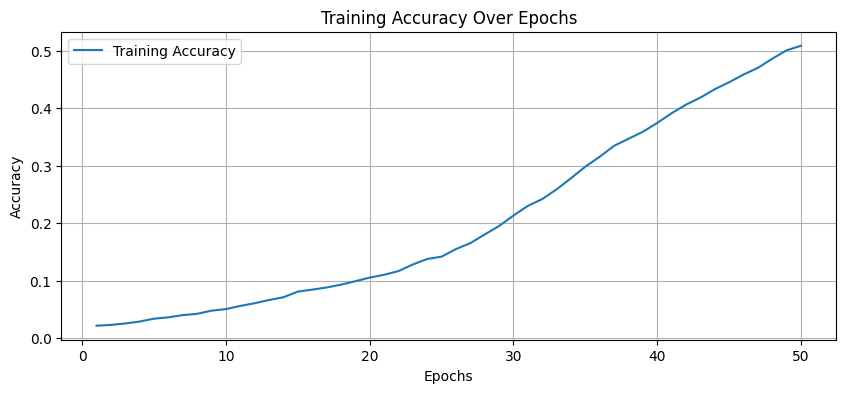

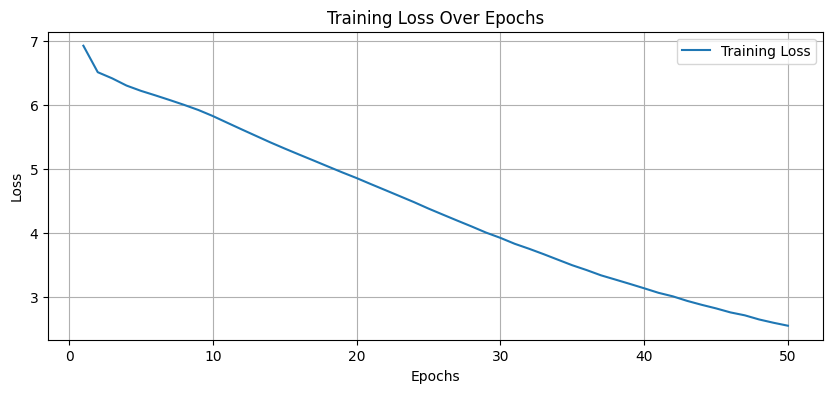

In [20]:
# Your code here :
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, acc, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [21]:
# Your code here :
seed_text = "shall i compare thee to a summer's day"
next_words = 40


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [22]:
for _ in range(next_words):
    # Convert seed text to token sequence
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict next word
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = predicted_probs.argmax()

    # Convert index → word
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    # Append predicted word to seed text
    seed_text += " " + output_word

print(seed_text)


shall i compare thee to a summer's day wastes one ' ' ' can none none much old hell staineth dun ' more near thee or me bright die one hate now hate find ' ' of rolling rolling sort ' lived can grew more near men go


In [ ]:
# Your code here :
# Seed text 1:
seed_text = "the night was silent as the stars whispered"
next_words = 40

# Seed text 2:
seed_text = "in the quiet hum of a distant memory"
next_words = 40

# Seed text 3:
seed_text = "when shadows gather at the edge of dawn"
next_words = 40

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = predicted_probs.argmax()

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += " " + output_word

print(seed_text)



when shadows gather at the edge of dawn argument friend now shown go level in thee fair eye day words thee prove go worth forth words more ill forth worth forth words forth times eye forth more forth eye times eye eye of lease forth it sad dearly


In [24]:
# Seed text 2:
seed_text = "in the quiet hum of a distant memory"
next_words = 40


for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = predicted_probs.argmax()

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += " " + output_word

print(seed_text)


in the quiet hum of a distant memory taste ill part of me more eyes lived lies eyes strong lie in me more ill of thee ' lies young in rest age more near more strong treasure dyed of day dead near green crime green crime lie in


In [25]:
seed_text = "the night was silent as the stars whispered"
next_words = 40

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = predicted_probs.argmax()

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += " " + output_word

print(seed_text)


the night was silent as the stars whispered may take it hate convertest be gone forth green truth forth words forth day forth told of beauty eye can change me in it deeds do men cross lie in thee forth thee still eye can forgot so best '


CONCLUSION:

This lab successfully demonstrated the process of training a neural network to generate new text in the style of Shakespeare’s sonnets. By transforming raw text into numerical sequences, building an LSTM-based language model, and training it on the entire corpus, we created a system that can predict and generate coherent word sequences that resemble Early Modern English. Through multiple stages — tokenization, sequence construction, model design, training, and inference — we developed a deeper understanding of how sequential models learn linguistic structure and use probability distributions to predict likely next words. The final model was able to produce stylized and creative text that captures aspects of Shakespeare’s writing patterns. Overall, the project provided hands-on insight into the capabilities and limitations of neural text generation.

Reflection / What I Learned:
During this lab, I gained valuable experience in the entire workflow of natural language processing using deep learning.
Key takeaways include:
    - Tokenization and preprocessing are crucial steps that greatly influence model performance. Understanding how text is converted into sequences helped clarify how models “see” language.
    - Sequence generation using n-grams allows the model to learn contextual relationships between words rather than isolated tokens.
    - LSTM and Bidirectional LSTM layers are powerful tools for capturing long-term dependencies, especially in poetic or archaic language like Shakespeare’s.
    - One-hot encoding and softmax outputs helped reinforce how classification models work in multi-class settings.
    - Training visualization showed how accuracy and loss evolve over time and highlighted the importance of tuning epochs and regularization.
    - Generating text with custom seed inputs demonstrated how the model uses learned patterns to produce stylistically consistent but novel text.
This lab deepened my understanding of NLP workflows, sequence modeling, and the creative potential of machine learning.

Abstract
This lab explores text generation using a recurrent neural network trained on Shakespeare’s sonnets. The project focuses on preparing the dataset, building a tokenizer, generating n-gram sequences, and training a deep learning model capable of predicting the next word in a sequence. A multi-layer architecture featuring an embedding layer, bidirectional LSTM, dropout, and dense layers was developed and trained on the corpus. After training for 50 epochs, the model achieved approximately 40% accuracy. The trained model was then used to generate new text, producing outputs resembling Shakespeare’s poetic style. This lab provides hands-on experience in natural language processing, sequence modeling, and neural text generation.

Future Improvements:
There are several ways this project could be expanded or enhanced:
 1. Use a larger or more diverse dataset
    Including Shakespeare’s full plays, sonnets, or Elizabethan-era texts could improve the model’s creativity and fluency.

 2. Add temperature sampling
    Adjusting randomness during prediction using temperature scaling can yield more creative or more controlled text generation.

 3. Train for more epochs with early stopping
    Additional training (100–200 epochs) or using callbacks like EarlyStopping could improve performance while preventing overfitting.

 4. Use pretrained language models
    Experimenting with GPT-based transformers or using embeddings like GloVe could dramatically improve output quality.

 5. Implement beam search decoding
    Beam search can produce more coherent text by exploring multiple candidate word sequences at each prediction step.
    
 6. Explore character-level 
    A character-level LSTM can generate stylistic elements like punctuation, capitalization, and rhyming patterns more precisely.
